In [444]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

c:\Users\Elbert\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Helper Functions

In [242]:
def R(W, alpha):
    eValues,_ = np.linalg.eig(W)
    abscissa = max(eValues)

    return np.real(W * alpha/abscissa)

def matrixHeatMap(matrix):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('j')
    plt.ylabel('i')

### V1 Model Class Definition

In [333]:
class V1Model:
    def __init__(self, m, n):
        # Default parameters
        self.tau = 0.02 #s 20ms
        self.m = m # number of quantisations of angle
        self.n = n # number of neurons in V1
        self.B = None # matrix of weights applied to inputs to V1 dynamics, h(theta)
        self.C = None # matrix of output weights applied to outputs from V1 dynamics
        self.sigma = 1 # amplitude of noise applied to V1 dynamics output
        self.kappa = np.pi/4 # reciprocal exponential scaling factor applied to angles to give h(theta)
        self.alpha = 0.9 # scale given to abscissa of W
        self.alpha2 = 0.9 # secondary abscissa scale of W
        self.W = None # connectivity matrix (inter-neuron weights)

        # Modelling settings
        self.dt = 0.001 #s timesteps 1ms

        # Model variables
        self.theta = 0
        self.phi = np.arange(0,self.m) * 2*np.pi / self.m
        self.h = np.zeros(self.m)
        self.r = np.zeros(self.n)
        self.noisyOutput = np.zeros(self.m)
        self.thetaEst = 0
        self.decodeError = 0
    
    def V(self, angle):
        return np.exp((np.cos(angle) - 1) / self.kappa**2)

    def hCalc(self):
        self.h = self.V(self.phi - self.theta)
    
    def rIntegrate(self):
        self.r = self.r + self.dt/self.tau * (-self.r + np.matmul(self.W, self.r) + np.matmul(self.B, self.h))

    def calcOutput(self):
        self.noisyOutput = np.matmul(self.C, self.r) + self.sigma*np.random.normal(0,1,self.m)
    
    def estimateTheta(self):
        self.thetaEst = math.atan2(sum(self.noisyOutput * np.sin(self.phi)), sum(self.noisyOutput * np.cos(self.phi)))
    
    def calcError(self):
        self.decodeError = np.arccos(np.cos(self.thetaEst - self.theta))
        
    def stepTime(self):
        self.hCalc()
        self.rIntegrate()
        self.calcOutput()
        self.estimateTheta()
        self.calcError()


### Model Initiation Functions

In [659]:
def setModel1():# W = 0
    model1 = V1Model(200,200)
    model1.W = np.zeros((model1.m, model1.m))
    model1.B, model1.C = np.diag(np.ones(model1.m)), np.diag(np.ones(model1.m))
    return model1

def setModel2(alpha=0.9): # W = rescaled random W+W.t
    model2 = V1Model(200,200)
    np.random.seed(6969)
    WBar2 = np.random.normal(0,1,(model2.m, model2.m))
    np.random.seed(None)

    model2.alpha = alpha
    model2.W = R(WBar2+WBar2.T, model2.alpha)
    model2.B, model2.C = np.diag(np.ones(model2.m)), np.diag(np.ones(model2.m))
    
    return model2

def setModel3(alpha=0.9): # WIJ = V(phiI - phiJ)
    model3 = V1Model(200,200)
    WBar3 = np.zeros((model3.m, model3.m))

    for i in range(WBar3.shape[0]):
        for j in range(WBar3.shape[1]):
            WBar3[i,j] = model3.V(model3.phi[i] - model3.phi[j])

    model3.alpha = alpha
    model3.W = R(WBar3, model3.alpha)
    model3.B, model3.C = np.diag(np.ones(model3.m)), np.diag(np.ones(model3.m))
    return model3

def setModel4(alpha=0.9, B=np.array([]), C=np.array([])): # n=2m more neurons than angles, W = ring structure like model 3
    model4 = V1Model(200,400)

    WBar3 = np.zeros((model4.m, model4.m))
    for i in range(WBar3.shape[0]):
        for j in range(WBar3.shape[1]):
            WBar3[i,j] = model4.V(model4.phi[i] - model4.phi[j])
    
    model4.n = 2*model4.m
    model4.alpha2 = alpha
    WBar4 = R(WBar3, model4.alpha2)
    W = np.concatenate((WBar4, -WBar4), axis=1)
    model4.W = np.concatenate((W, W), axis=0)
    
    if B.shape[0]==0:
        model4.B = np.concatenate((np.diag(np.ones(model4.m)), np.zeros((model4.m, model4.m))), axis=0)
    else:
        model4.B = B

    if C.shape[0]==0:
        model4.C = np.concatenate((np.diag(np.ones(model4.m)), np.zeros((model4.m, model4.m))), axis=1)
    else:
        model4.C = C
    return model4

### Exercise 1 - integrating all models with their default parameters

In [495]:
# Initialise models
model1 = setModel1()
model2 = setModel2()
model3 = setModel3()
model4 = setModel4()
models = [model1, model2, model3, model4]
letters = ['a','b','c','d','e','f','g']
defaultColors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# 1ms steps are set as default
responses = [[] for _ in models]
noisyResponses = [[] for _ in models]
thetaEst = [[] for _ in models]
errors = [[] for _ in models]

timesteps = np.arange(0,201)
qTimes = [10,50,100,200]

for i, model in enumerate(models):
    model.theta = np.pi

    for t in timesteps:
        responses[i].append(model.r)
        noisyResponses[i].append(model.noisyOutput)
        thetaEst[i].append(model.thetaEst)
        errors[i].append(model.decodeError)
        model.stepTime()

C:\Users\Elbert\AppData\Local\Temp\ipykernel_11888\2758869045.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


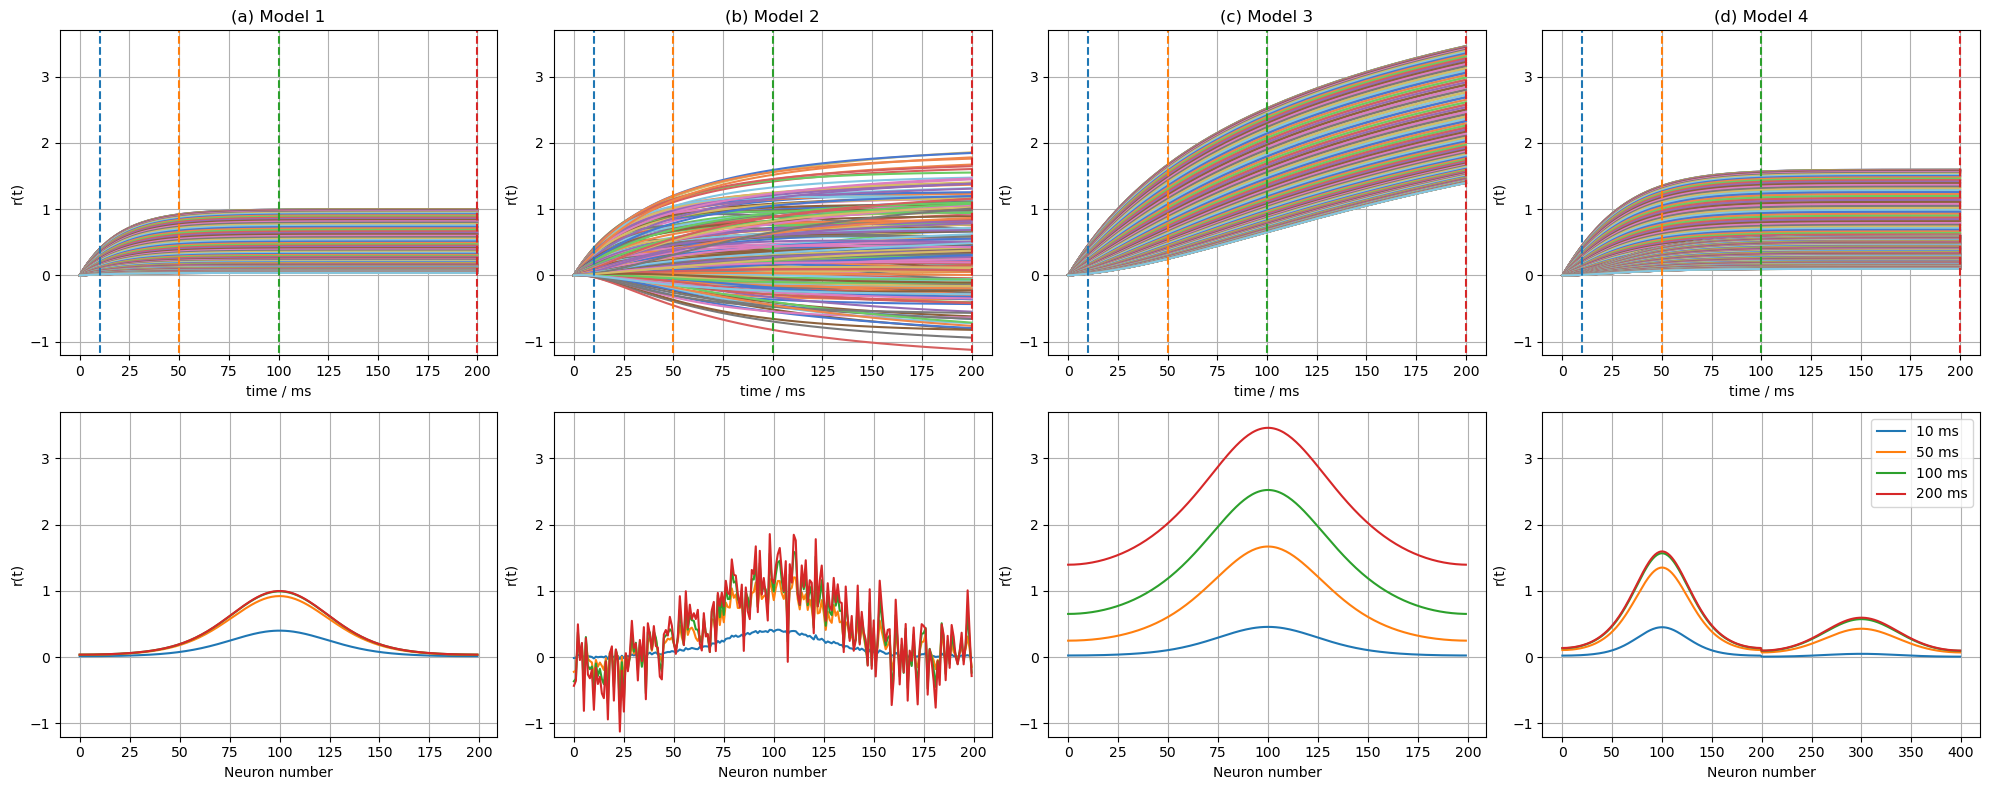

In [496]:
sns.set_palette('muted')
fig,ax = plt.subplots(2,4, figsize=[20,8])

for i in range(len(models)):
    
    ax[0,i].plot(timesteps, responses[i])
    ax[0,i].vlines(qTimes, -1.5, 4, colors=defaultColors[:4], linestyle='--')
    ax[0,i].grid()
    ax[0,i].set_title(f'({letters[i]}) Model {i+1}')
    ax[0,i].set_xlabel('time / ms')
    ax[0,i].set_ylabel('r(t)')
    ax[0,i].set_ylim([-1.2,3.7])
    
    neurons = np.arange(0,models[i].n)
    for j, time in enumerate(qTimes):
        ax[1,i-4].plot(neurons, responses[i][time], color=defaultColors[j])
    ax[1,i-4].grid()
    ax[1,i-4].set_xlabel('Neuron number')
    ax[1,i-4].set_ylabel('r(t)')
    ax[1,i-4].set_ylim([-1.2,3.7])

ax[1,-1].legend([f'{qTime} ms' for qTime in qTimes])
fig.tight_layout(h_pad=1, w_pad=0.5)
fig.show()

sns.set_palette('tab10')

### Exercise 2 - model 2 explanation, ANY OTHER METRICS?

0.900000000000001


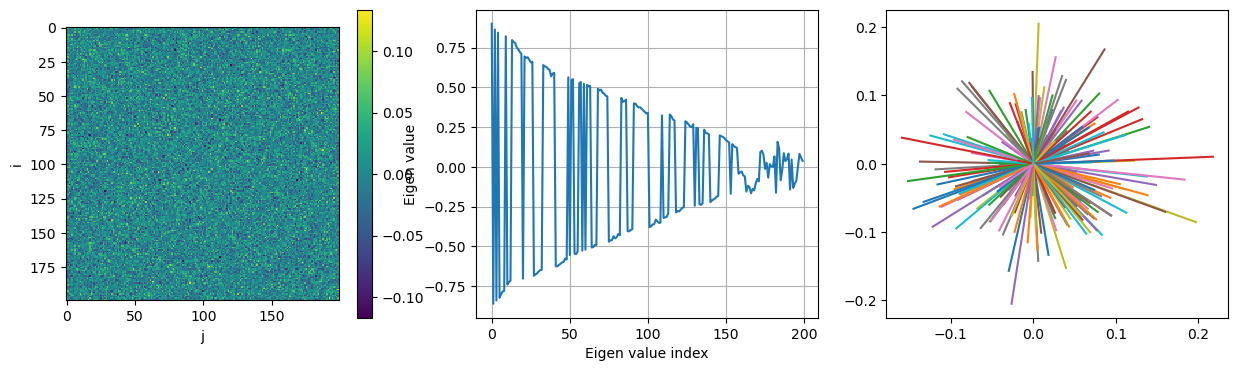

In [404]:
plt.figure(figsize=[15,4])

eValues,eVectors = np.linalg.eig(models[1].W)
print(max(eValues))

plt.subplot(1,3,1)
matrixHeatMap(models[1].W)

plt.subplot(1,3,2)
plt.plot(np.arange(0,eValues.shape[0]), eValues)
plt.grid()
plt.xlabel('Eigen value index')
plt.ylabel('Eigen value')

plt.subplot(1,3,3)
for i in range(len(eVectors)):
    plt.plot([0,eVectors[i][0]], [0,eVectors[i][1]])
    
plt.show()

### Exercise 3 - model 3 explanation
No inhibitory neuron activity, meaning all neurons are affected by the input signal, h(t) and have a response to this signal that grows monotonically with time

Since all neurons develop responses to the input regardless of angle, the Wr term continually increases the rate of change of r(t) per timestep, leading to the faster response to the stimulus

(0.9000000000000032+0j)


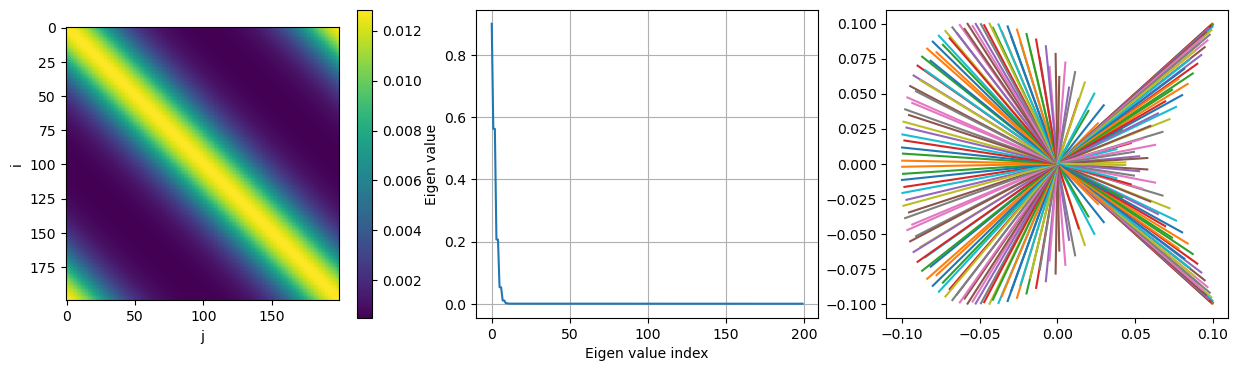

In [278]:
plt.figure(figsize=[15,4])

eValues,eVectors = np.linalg.eig(models[2].W)
print(max(eValues))

plt.subplot(1,3,1)
matrixHeatMap(models[2].W)

plt.subplot(1,3,2)
plt.plot(np.arange(0,eValues.shape[0]), eValues)
plt.grid()
plt.xlabel('Eigen value index')
plt.ylabel('Eigen value')

plt.subplot(1,3,3)
for i in range(len(eVectors)):
    plt.plot([0,eVectors[i][4]], [0,eVectors[i][6]])
plt.show()

### Exercise 4 - models 2,3 responding slower than 1,4

### Exercise 5 - 200ms decoding accuracy averaged over repeated trials with uniform random angular inputs

In [677]:
nModels = 7
modAlpha = 5
decodeAccuracies5 = [[] for _ in range(nModels)]
timesteps = np.arange(0,201)

for trial in tqdm(range(1000)):
    randTheta = np.random.uniform(0,2*np.pi,1)
    for i in range(nModels):
        if i>3:
            model = eval(f'setModel{i-2}(alpha={modAlpha})')
        else:
            model = eval(f'setModel{i+1}()')
            
        model.theta = randTheta
        model.sigma = 1
        
        for t in timesteps:
            model.stepTime()
        
        decodeAccuracies5[i].append(model.decodeError)

100%|██████████| 1000/1000 [17:55<00:00,  1.08s/it]


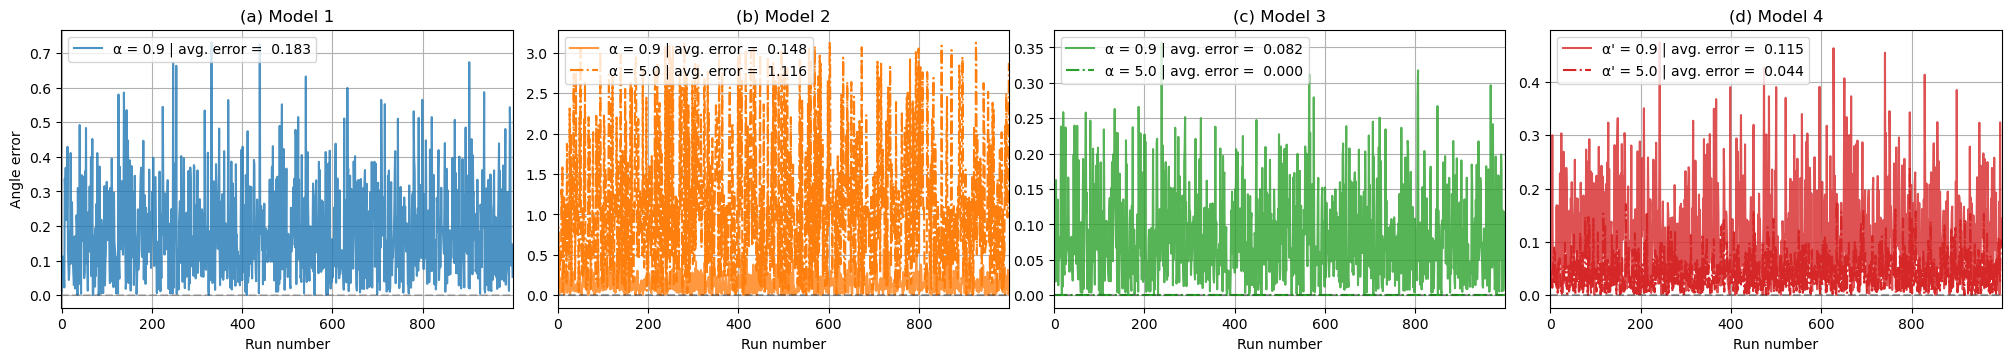

In [678]:
fig, ax = plt.subplots(1,4, figsize=[20,3.5])

for i in range(nModels):
    idx = i
    if i>3:
        idx = i-3
        if i==6:
            ax[idx].plot(decodeAccuracies5[i], color=defaultColors[idx], linestyle='-.', label=f"α' = 5.0 | avg. error = {np.mean(decodeAccuracies5[i]) : .3f}")
        else:
            ax[idx].plot(decodeAccuracies5[i], color=defaultColors[idx], linestyle='-.', label=f"α = 5.0 | avg. error = {np.mean(decodeAccuracies5[i]) : .3f}")
        ax[idx].grid()
    else:
        if i==3:
            ax[idx].plot(decodeAccuracies5[i], color=defaultColors[idx], alpha=0.8, label=f"α' = 0.9 | avg. error = {np.mean(decodeAccuracies5[i]) : .3f}")
        else:
            ax[idx].plot(decodeAccuracies5[i], color=defaultColors[idx], alpha=0.8, label=f"α = 0.9 | avg. error = {np.mean(decodeAccuracies5[i]) : .3f}")

    ax[idx].hlines(0,-2,len(decodeAccuracies5[idx])+2, color='black', linestyle='--', alpha=0.2, label='_Hidden')
    ax[idx].set_title(f'({letters[idx]}) Model {idx+1}')
    ax[idx].set_xlabel('Run number')

    ax[idx].set_xlim(-0.5, len(decodeAccuracies5[idx])-0.5)
    # ax[idx].set_ylim(-0.02, np.pi)
    # ax[idx].set_yscale('log')
    ax[idx].grid()

    if i!=0:
        # ax[idx].set_yticklabels([])
        i=i
    else:
        ax[idx].set_ylabel('Angle error')

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
ax[3].legend(loc='upper left')
fig.tight_layout(pad=0.3)
plt.show()

### Exercise 6 - model 4 with alpha' = 5

In [577]:
# Initialise models
model2 = setModel2()
model2Fast = setModel2(alpha=5)
model3 = setModel3()
model3Fast = setModel3(alpha=5)
model4 = setModel4()
model4Fast = setModel4(alpha=5)
models = [model2, model2Fast, model3, model3Fast, model4, model4Fast]

# 1ms steps are set as default
responses = [[] for _ in models]

timesteps = np.arange(0,201)
qTimes = [10,50,100,200]

for i, model in enumerate(models):
    model.theta = np.pi

    for t in timesteps:
        responses[i].append(model.r)
        model.stepTime()

C:\Users\Elbert\AppData\Local\Temp\ipykernel_11888\3963404204.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


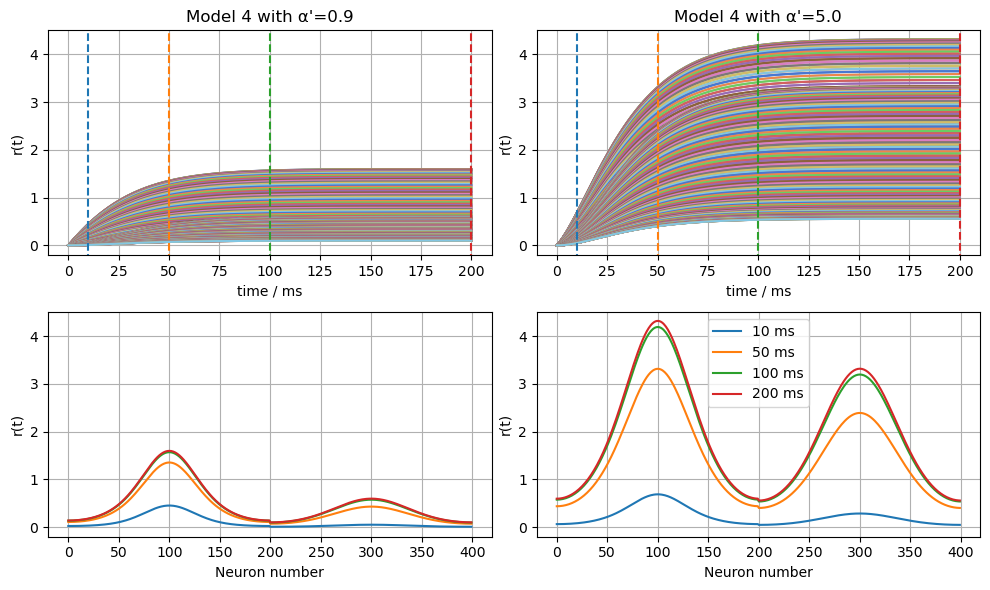

In [570]:
sns.set_palette('muted')
fig,ax = plt.subplots(2,2, figsize=[10,6])

for i, modelIdx in enumerate([4,5]):
    ax[0,i].plot(timesteps, responses[modelIdx])
    ax[0,i].vlines(qTimes, -1.5, 5, colors=defaultColors[:4], linestyle='--')
    ax[0,i].grid()
    ax[0,i].set_xlabel('time / ms')
    ax[0,i].set_ylabel('r(t)')
    ax[0,i].set_ylim([-0.2,4.5])
    
    neurons = np.arange(0,models[modelIdx].n)
    for j, time in enumerate(qTimes):
        ax[1,i-2].plot(neurons, responses[modelIdx][time], color=defaultColors[j])
    ax[1,i-2].grid()
    ax[1,i-2].set_xlabel('Neuron number')
    ax[1,i-2].set_ylabel('r(t)')
    ax[1,i-2].set_ylim([-0.2,4.5])

ax[0,0].set_title("Model 4 with α'=0.9")
ax[0,1].set_title("Model 4 with α'=5.0")
ax[1,-1].legend([f'{qTime} ms' for qTime in qTimes])
fig.tight_layout(h_pad=1, w_pad=0.5)
fig.show()

sns.set_palette('tab10')

### Exercise 7 - models 2 and 3 with α=5
Something about unstable loci making the responses tend to infinity exponentially over time?

C:\Users\Elbert\AppData\Local\Temp\ipykernel_11888\3880195674.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


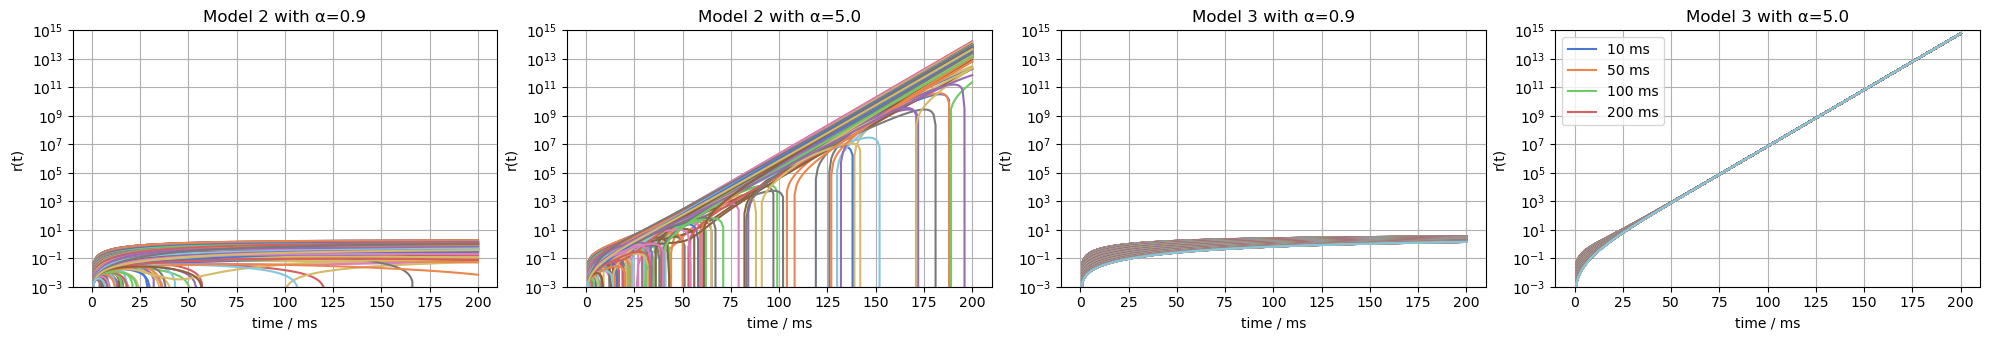

In [600]:
sns.set_palette('muted')
fig,ax = plt.subplots(1,4,figsize=[20,3.5])

for i, modelIdx in enumerate([0,1,2,3]):
    ax[i].plot(timesteps, responses[modelIdx])
    ax[i].grid()
    ax[i].set_xlabel('time / ms')
    ax[i].set_ylabel('r(t)')
    ax[i].set_ylim([1e-3,1e15])
    ax[i].set_yscale('log')
    
ax[0].set_title("Model 2 with α=0.9")
ax[1].set_title("Model 2 with α=5.0")
ax[2].set_title("Model 3 with α=0.9")
ax[3].set_title("Model 3 with α=5.0")

ax[-1].legend([f'{qTime} ms' for qTime in qTimes])
fig.tight_layout(h_pad=1, w_pad=0.5)
fig.show()

sns.set_palette('tab10')

### Exercise 8 - input weights matrix, B, for model 4
Try to use -I matrix in the bottom half of B to inhibit other neurons

In [652]:
# Initialise models
model4 = setModel4()
BQ8 = np.concatenate((np.diag(np.ones(model4.m)), -np.diag(np.ones(model4.m))), axis=0)
model4Q8 = setModel4(B=BQ8)
models = [model4, model4Q8]

# 1ms steps are set as default
responses = [[] for _ in models]

timesteps = np.arange(0,201)
qTimes = [10,50,100,200]

for i, model in enumerate(models):
    model.theta = np.pi

    for t in timesteps:
        responses[i].append(model.r)
        model.stepTime()

C:\Users\Elbert\AppData\Local\Temp\ipykernel_11888\3016506220.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


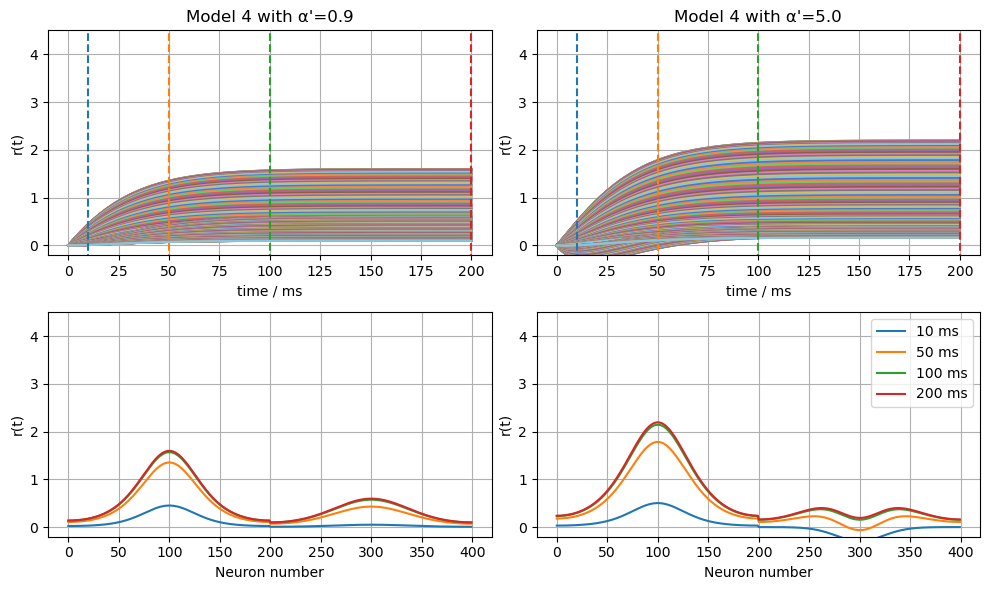

In [653]:
sns.set_palette('muted')
fig,ax = plt.subplots(2,2, figsize=[10,6])

for i, modelIdx in enumerate([0,1]):
    ax[0,i].plot(timesteps, responses[modelIdx])
    ax[0,i].vlines(qTimes, -1.5, 5, colors=defaultColors[:4], linestyle='--')
    ax[0,i].grid()
    ax[0,i].set_xlabel('time / ms')
    ax[0,i].set_ylabel('r(t)')
    ax[0,i].set_ylim([-0.2,4.5])
    
    neurons = np.arange(0,models[modelIdx].n)
    for j, time in enumerate(qTimes):
        ax[1,i-2].plot(neurons, responses[modelIdx][time], color=defaultColors[j])
    ax[1,i-2].grid()
    ax[1,i-2].set_xlabel('Neuron number')
    ax[1,i-2].set_ylabel('r(t)')
    ax[1,i-2].set_ylim([-0.2,4.5])

ax[0,0].set_title("Model 4 with α'=0.9")
ax[0,1].set_title("Model 4 with α'=5.0")
ax[1,-1].legend([f'{qTime} ms' for qTime in qTimes])
fig.tight_layout(h_pad=1, w_pad=0.5)
fig.show()

sns.set_palette('tab10')

In [686]:
models = ["setModel4()", "setModel4(B=BQ8)", "setModel4(alpha=5.0)", "setModel4(alpha=5.0, B=BQ8)"]
decodeAccuracies8 = [[] for _ in range(len(models))]
timesteps = np.arange(0,201)

BQ8 = np.concatenate((np.diag(np.ones(model4.m)), -np.diag(np.ones(model4.m))), axis=0)

for trial in tqdm(range(1000)):
    randTheta = np.random.uniform(0,2*np.pi,1)
    for i in range(len(models)):
        model = eval(models[i])
        
        model.theta = randTheta
        model.sigma = 1
        
        for t in timesteps:
            model.stepTime()
        
        decodeAccuracies8[i].append(model.decodeError)

100%|██████████| 1000/1000 [11:53<00:00,  1.40it/s]


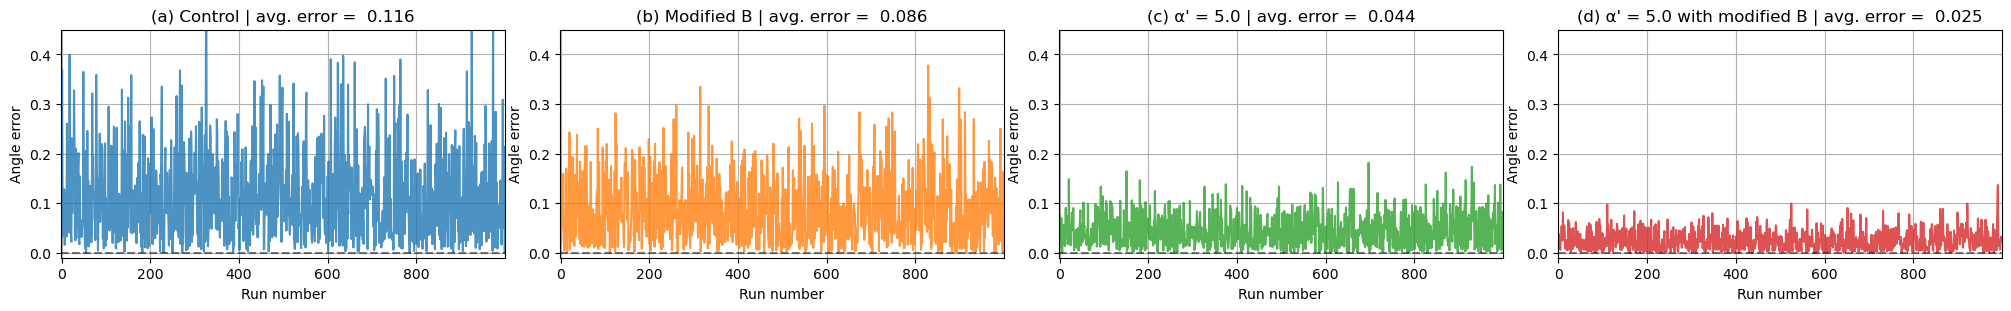

In [690]:
fig,ax = plt.subplots(1,4,figsize=[20,3])

plotLabels = [f"Control",
              f"Modified B",
              f"α' = 5.0",
              f"α' = 5.0 with modified B"]

for i in range(len(models)):
    ax[i].plot(decodeAccuracies8[i], color=defaultColors[i], alpha=0.8)
    ax[i].hlines(0,-2,len(decodeAccuracies8[0])+2, color='black', linestyle='--', alpha=0.5)

    ax[i].set_title(f"({letters[i]}) {plotLabels[i]} | avg. error = {np.mean(decodeAccuracies8[i]): .3f}")
    ax[i].set_xlabel('Run number')
    ax[i].set_ylabel('Angle error')

    ax[i].set_xlim(-0.5, len(decodeAccuracies8[0])-0.5)
    ax[i].set_ylim(-0.01, 0.45)
    ax[i].grid()

fig.tight_layout(pad=0.3)
plt.show()

### Exercise 9 - output weights matrix, C, for model 4
-I in the right half of C to nerf all weights except for the excitatory neurons that correspond to the actual angle

In [671]:
# Initialise models
model4 = setModel4()
CQ9 = np.concatenate((np.diag(np.ones(model4.m)), np.diag(np.ones(model4.m))), axis=1)
model4Q9 = setModel4(C=CQ9)
models = [model4, model4Q9]

# 1ms steps are set as default
responses = [[] for _ in models]

timesteps = np.arange(0,201)
qTimes = [10,50,100,200]

for i, model in enumerate(models):
    model.theta = np.pi
    for t in timesteps:
        responses[i].append(model.r)
        model.stepTime()

(200, 400)
(200, 400)


C:\Users\Elbert\AppData\Local\Temp\ipykernel_11888\3016506220.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


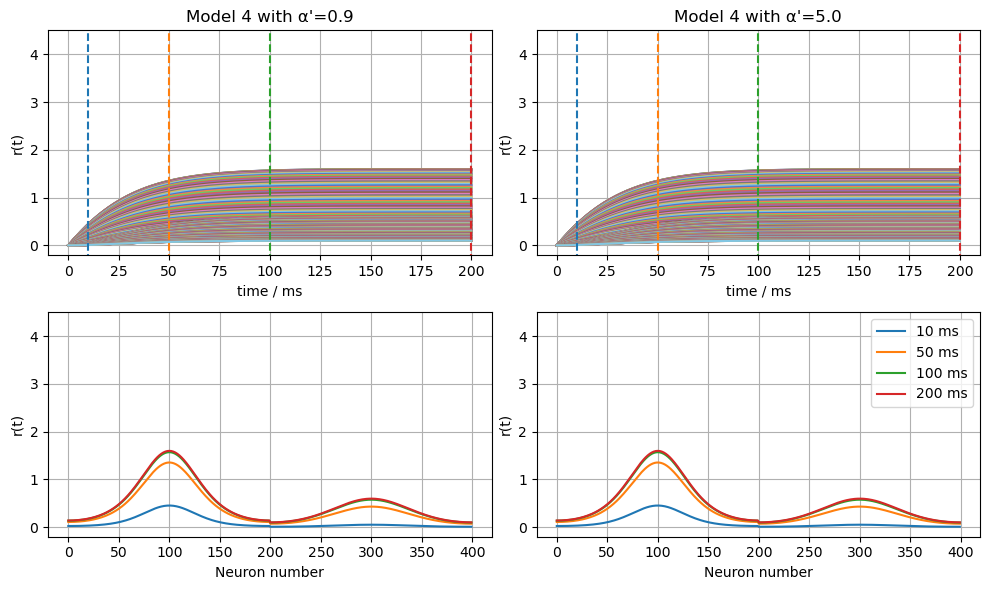

In [672]:
sns.set_palette('muted')
fig,ax = plt.subplots(2,2, figsize=[10,6])

for i, modelIdx in enumerate([0,1]):
    ax[0,i].plot(timesteps, responses[modelIdx])
    ax[0,i].vlines(qTimes, -1.5, 5, colors=defaultColors[:4], linestyle='--')
    ax[0,i].grid()
    ax[0,i].set_xlabel('time / ms')
    ax[0,i].set_ylabel('r(t)')
    ax[0,i].set_ylim([-0.2,4.5])
    
    neurons = np.arange(0,models[modelIdx].n)
    for j, time in enumerate(qTimes):
        ax[1,i-2].plot(neurons, responses[modelIdx][time], color=defaultColors[j])
    ax[1,i-2].grid()
    ax[1,i-2].set_xlabel('Neuron number')
    ax[1,i-2].set_ylabel('r(t)')
    ax[1,i-2].set_ylim([-0.2,4.5])

ax[0,0].set_title("Model 4 with α'=0.9")
ax[0,1].set_title("Model 4 with α'=5.0")
ax[1,-1].legend([f'{qTime} ms' for qTime in qTimes])
fig.tight_layout(h_pad=1, w_pad=0.5)
fig.show()

sns.set_palette('tab10')

In [691]:
models = ["setModel4()", "setModel4(C=CQ9)", "setModel4(alpha=5.0)", "setModel4(alpha=5.0, C=CQ9)"]
decodeAccuracies9 = [[] for _ in range(len(models))]
timesteps = np.arange(0,201)

BQ8 = np.concatenate((np.diag(np.ones(model4.m)), -np.diag(np.ones(model4.m))), axis=0)

for trial in tqdm(range(1000)):
    randTheta = np.random.uniform(0,2*np.pi,1)
    for i in range(len(models)):
        model = eval(models[i])
        
        model.theta = randTheta
        model.sigma = 1
        
        for t in timesteps:
            model.stepTime()

        decodeAccuracies9[i].append(model.decodeError)

 10%|▉         | 97/1000 [01:13<11:24,  1.32it/s]

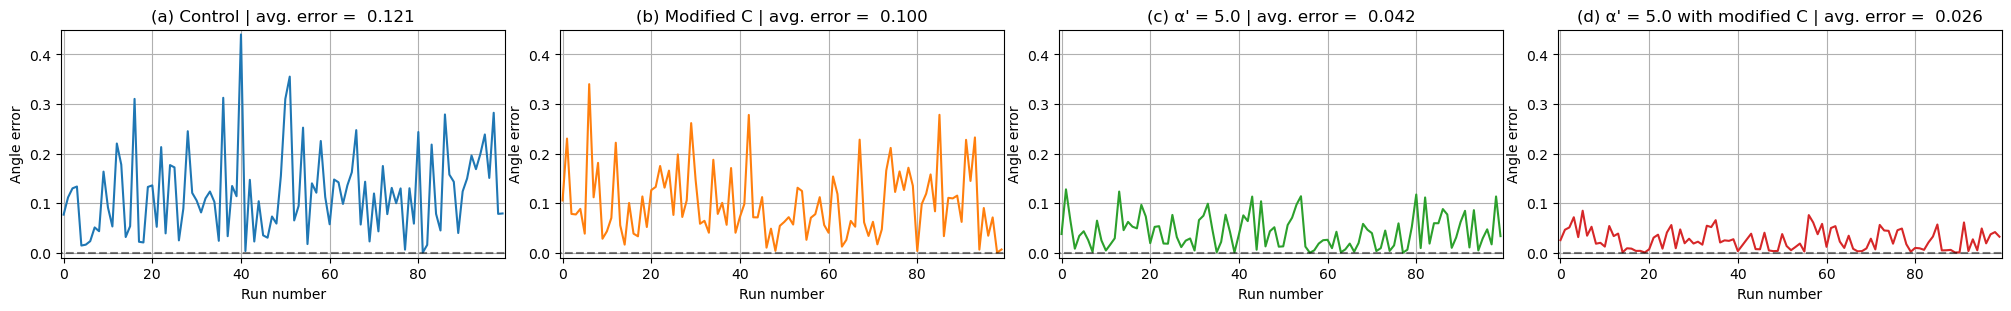

In [689]:
fig,ax = plt.subplots(1,4,figsize=[20,3])

plotLabels = [f"Control",
              f"Modified C",
              f"α' = 5.0",
              f"α' = 5.0 with modified C"]

for i in range(len(models)):
    ax[i].plot(decodeAccuracies9[i], color=defaultColors[i])
    ax[i].hlines(0,-2,len(decodeAccuracies9[0])+2, color='black', linestyle='--', alpha=0.5)

    ax[i].set_title(f"({letters[i]}) {plotLabels[i]} | avg. error = {np.mean(decodeAccuracies9[i]): .3f}")
    ax[i].set_xlabel('Run number')
    ax[i].set_ylabel('Angle error')

    ax[i].set_xlim(-0.5, len(decodeAccuracies9[0])-0.5)
    ax[i].set_ylim(-0.01, 0.45)
    ax[i].grid()

fig.tight_layout(pad=0.3)
plt.show()

In [ ]:
import pickle

with open('decodeAccuracies5', 'wb') as f:
    pickle.dump(decodeAccuracies5, f)
    f.close

with open('decodeAccuracies8', 'wb') as f:
    pickle.dump(decodeAccuracies8, f)
    f.close

with open('decodeAccuracies9', 'wb') as f:
    pickle.dump(decodeAccuracies9, f)
    f.close